

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персонажи менялись вместе с изменяющимися графическими технологиями и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перезагрузите данный ноутбук:

In [ ]:
!pip install -U torch torchvision

In [2]:
import torch
import numpy as np
import torch.nn.functional as F
import random

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [ ]:
#Альтернативный способ получения данных
'''
pip install kaggle
!kaggle competitions download -c journey-springfield
!unzip -qq journey-springfield.zip

TRAIN_DIR = Path('train/simpsons_dataset/')
TEST_DIR = Path('testset/testset')

ну до этого конечно проинсталлить и импортировать kaggle 
и переменные среды прописать или json с каггла запихнуть в сессию
'''

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
#!unzip -q /content/gdrive/Kaggle/journey-springfield.zip

!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [ ]:
!ls -1

characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 28 18:16:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [6]:
!pip install torchinfo
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

from matplotlib import colors, pyplot as plt
from sklearn.metrics import f1_score
%matplotlib inline

import gc

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
device = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [8]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [9]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

Борьба с дисбалансом классов

In [12]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [13]:
def create_dct_labels_path(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [14]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_labels_path(train_files, train_labels)

In [ ]:
# Посмотрим, что у нас получилось.
#print_dct(dct_path_train)

In [15]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
      if person in ['cletus_spuckler', 'cletus_spuckler', 'barney_gumble', 'maggie_simpson']:
        dct_path_train[person] = dct_path_train[person] * (150 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:150 - len(dct_path_train[person])])
      else:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [18]:
# Проверим что получилось 
size = 0
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")
    size += len(dct_path_train[person])
print(size)

abraham_grampa_simpson	730
agnes_skinner	100
apu_nahasapeemapetilon	498
barney_gumble	150
bart_simpson	1074
carl_carlson	100
charles_montgomery_burns	954
chief_wiggum	789
cletus_spuckler	150
comic_book_guy	375
disco_stu	100
edna_krabappel	366
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1797
kent_brockman	398
krusty_the_clown	965
lenny_leonard	248
lionel_hutz	100
lisa_simpson	1083
maggie_simpson	102
marge_simpson	1033
martin_prince	100
mayor_quimby	197
milhouse_van_houten	863
miss_hoover	100
moe_szyslak	1161
ned_flanders	1163
nelson_muntz	286
otto_mann	100
patty_bouvier	100
principal_skinner	955
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	702
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	145
17984


In [19]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])


In [21]:
train_dataset = SimpsonsDataset(new_train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [20]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(224,pad_if_needed=True, padding_mode='reflect'),
            transforms.ColorJitter(brightness=0.2, contrast = .1, saturation=0.3),
            #transforms.CenterCrop((RESCALE_SIZE, RESCALE_SIZE)),
            #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        elif self.mode == 'test':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop(224,pad_if_needed=True, padding_mode='reflect'),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        else:
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Давайте посмотрим на наших героев внутри датасета.

In [24]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

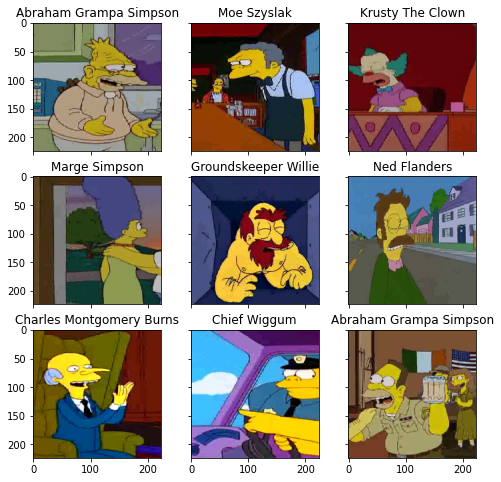

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,14000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Процесс обучения

In [25]:
# f1 micro == accuracy
def f1_torch(y_true, y_pred):

  y_true = F.one_hot(y_true.long(), 42).to(torch.float32)
  y_pred = F.one_hot(y_pred.long(), 42).to(torch.float32)

  tp = (y_true * y_pred).sum().to(torch.float32)
  tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
  fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
  fn = (y_true * (1 - y_pred)).sum().to(torch.float32)

  epsilon = 1e-7
    
  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)
    
  f1 = (2* (precision*recall) / (precision + recall + epsilon))
  return f1

In [26]:
#Сохранение и загрузка весов модели при заданной архитектуре
def save_model(model, name, i):
  torch.save(model.state_dict(), f"/content/gdrive/MyDrive/{name}_{i}_weights.pth") 

def load_model(model, name, i):
  state_dict = torch.load(f"/content/gdrive/MyDrive/{name}_{i}_weights.pth")
  model.load_state_dict(state_dict)
  return model

In [27]:
def accurancy_for_each_class(y_test_all, predictions_all, dataloader):
    class_correct = [0 for i in range(42)]
    class_total = [0 for i in range(42)]
    feature_names = sorted(set(dataloader.dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(42):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [28]:
def train_val(model, optimizer, scheduler, loss_function, batch_size, max_epochs, i, InceptionNet = False):
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  epoch_train_loss, epoch_val_loss = [0], [0]
  epoch_train_acc, epoch_val_acc, epoch_val_f1_w = [0], [0], [0]
  for i_epoch in range(max_epochs):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    print('Эпоха {}/{}'.format(i_epoch + 1, max_epochs), flush=True)

    for phase in ['train', 'val']:
      if phase == 'train':
        dataloader = train_loader
        model.train()
      else:
        dataloader = val_loader
        model.eval() 
        y_test_all = torch.Tensor().long()
        predictions_all = torch.Tensor().long()

      running_loss = 0.
      running_acc  = 0.
      running_f1_w = 0.
      
      for input, label in tqdm(dataloader):
        input = input.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          
          if InceptionNet and (phase == 'train'):
            out, aux1, aux2 = model(input)
            loss1 = loss_function(out, label)
            loss2 = loss_function(aux1, label)
            loss3 = loss_function(aux2, label)
            loss = loss1 + 0.3*(loss2 + loss3)
            preds = torch.argmax(out, 1)
          else:
            out = model(input)
            loss = loss_function(out, label)
            preds = torch.argmax(out, 1)
            
          if phase == 'train':
            loss.backward()
            optimizer.step()
          elif i_epoch == max_epochs-1:
            y_test_all = torch.cat((y_test_all, label.cpu()), 0)
            predictions_all = torch.cat((predictions_all, preds.cpu()), 0)
            
        running_loss += loss.item()
        running_acc += (preds == label.data).float().mean()
        running_f1_w += f1_score(label.data.cpu(), preds.cpu().numpy(), average='weighted')

      if phase == 'train':
        epoch_train_loss.append(running_loss/len(dataloader))
        epoch_train_acc.append(running_acc.cpu().numpy()/len(dataloader))
        print()
        print('\nЛосс на обучении: ',  epoch_train_loss[-1], flush=True)
        print('Точность на обучении: ', epoch_train_acc[-1], flush=True)
      else:
        epoch_val_loss.append(running_loss/len(dataloader))
        epoch_val_acc.append(running_acc.cpu().numpy()/len(dataloader))
        epoch_val_f1_w.append(running_f1_w/len(dataloader))
        print()
        print('\nЛосс на валидации: ',  epoch_val_loss[-1], flush=True)
        print('Точность на валидации: ', epoch_val_acc[-1], flush=True)
        print('Взвешенный f1 на валидации: ', epoch_val_f1_w[-1], flush=True)
        print('-----------------------------------------------')
            


        
    scheduler.step()
      #input.cpu(), out.cpu(), label.cpu(), running_acc.cpu()

  accurancy_for_each_class(y_test_all.numpy(), predictions_all.numpy(), dataloader)
  #save_model(model, i)
  gc.collect()
  model.cpu()
  torch.cuda.empty_cache()

  return [epoch_train_loss, epoch_train_acc], [epoch_val_loss, epoch_val_acc]

### Resnet18

In [ ]:
# Лучшая модель(№9) 0.9277 [Если разморозить conv1 результат будет заметно лучше]
resnet18 = models.resnet18(pretrained = True)
model = resnet18
for param in model.parameters():
    param.requires_grad = False
model.layer4[1].bn1.weight.requires_grad = True
model.layer4[1].bn1.bias.requires_grad = True
model.layer4[1].conv2.weight.requires_grad = True
model.layer4[1].bn2.bias.requires_grad = True
model.layer4[1].bn2.weight.requires_grad = True
model.layer4[1].rely = nn.ReLU()
model.fc = nn.Linear(512, 42)
model = load_model(model, 'resnet18', 9)
loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.3)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 2, 1)

Эпоха 1/2


100%|██████████| 140/140 [02:47<00:00,  1.20s/it]



Лосс на обучении:  0.5330443984695843
Точность на обучении:  0.8576644897460938



100%|██████████| 33/33 [00:31<00:00,  1.06it/s]



Лосс на валидации:  0.6105821137175416
Точность на валидации:  0.824992728955818
Взвешенный f1 на валидации:  0.896271789676414
-----------------------------------------------
Эпоха 2/2



100%|██████████| 140/140 [02:49<00:00,  1.21s/it]



Лосс на обучении:  0.32527809951986586
Точность на обучении:  0.9216008867536273



100%|██████████| 33/33 [00:32<00:00,  1.03it/s]



Лосс на валидации:  0.49969004365530884
Точность на валидации:  0.8608448722145774
Взвешенный f1 на валидации:  0.9183225007901045


-----------------------------------------------
[174, 6, 123, 15, 303, 19, 219, 212, 5, 90, 1, 105, 4, 5, 21, 449, 99, 255, 57, 1, 282, 11, 240, 8, 40, 207, 2, 351, 268, 73, 5, 15, 257, 8, 8, 15, 14, 185, 5, 7, 2, 21]
42
Accuracy of abraham_grampa_simpson : 93 %
Accuracy of agnes_skinner : 83 %
Accuracy of apu_nahasapeemapetilon : 91 %
Accuracy of barney_gumble : 80 %
Accuracy of bart_simpson : 79 %
Accuracy of carl_carlson : 68 %
Accuracy of charles_montgomery_burns : 88 %
Accuracy of chief_wiggum : 87 %
Accuracy of cletus_spuckler : 80 %
Accuracy of comic_book_guy : 90 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 81 %
Accuracy of fat_tony : 75 %
Accuracy of   gil : 80 %
Accuracy of groundskeeper_willie : 90 %
Accuracy of homer_simpson : 83 %
Accuracy of kent_brockman : 91 %
Accuracy of krusty_the_clown : 89 %
Accuracy of lenny_leonard : 84 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 84 %
Accuracy of maggie_simpson : 90 %
Accuracy of marge_simpson : 94

In [ ]:
model = resnet18
loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.6e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 2, 1)

Эпоха 1/2


100%|██████████| 140/140 [02:42<00:00,  1.16s/it]



Лосс на обучении:  0.06576365735381842
Точность на обучении:  0.9858258928571428



100%|██████████| 33/33 [00:30<00:00,  1.07it/s]



Лосс на валидации:  0.21923230667457436
Точность на валидации:  0.9332750493829901
Взвешенный f1 на валидации:  0.9636263993403505
-----------------------------------------------
Эпоха 2/2



100%|██████████| 140/140 [02:45<00:00,  1.18s/it]



Лосс на обучении:  0.04062513671815395
Точность на обучении:  0.993170166015625



100%|██████████| 33/33 [00:31<00:00,  1.04it/s]



Лосс на валидации:  0.18637726907477234
Точность на валидации:  0.9463921749230587
Взвешенный f1 на валидации:  0.9710434794610725


-----------------------------------------------
[174, 7, 127, 16, 275, 20, 240, 196, 7, 89, 1, 92, 5, 5, 24, 463, 105, 241, 57, 1, 276, 25, 263, 11, 49, 217, 3, 301, 290, 66, 6, 16, 235, 11, 8, 18, 18, 175, 8, 11, 2, 33]
42
Accuracy of abraham_grampa_simpson : 97 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 95 %
Accuracy of barney_gumble : 93 %
Accuracy of bart_simpson : 90 %
Accuracy of carl_carlson : 95 %
Accuracy of charles_montgomery_burns : 94 %
Accuracy of chief_wiggum : 96 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 100 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 96 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 100 %
Accuracy of homer_simpson : 90 %
Accuracy of kent_brockman : 95 %
Accuracy of krusty_the_clown : 96 %
Accuracy of lenny_leonard : 96 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 93 %
Accuracy of maggie_simpson : 92 %
Accuracy of marge_sim

In [ ]:
resnet18 = models.resnet18(pretrained = True)
model = resnet18
for param in model.parameters():
    param.requires_grad = False
model.layer4[1].bn1.weight.requires_grad = True
model.layer4[1].bn1.bias.requires_grad = True
model.layer4[1].conv2.weight.requires_grad = True
model.layer4[1].bn2.bias.requires_grad = True
model.layer4[1].bn2.weight.requires_grad = True
model.layer4[1].rely = nn.ReLU()
model.fc = nn.Linear(512, 42)
model = load_model(model, 'resnet18', 9)
loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.3)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 2, 1)

Эпоха 1/2


100%|██████████| 140/140 [02:46<00:00,  1.19s/it]



Лосс на обучении:  0.15061279415552106
Точность на обучении:  0.957970210484096



100%|██████████| 33/33 [00:31<00:00,  1.05it/s]



Лосс на валидации:  0.26448214799165726
Точность на валидации:  0.9208604061242306
Взвешенный f1 на валидации:  0.9559309026144244
-----------------------------------------------
Эпоха 2/2



100%|██████████| 140/140 [02:46<00:00,  1.19s/it]



Лосс на обучении:  0.07604936858905213
Точность на обучении:  0.9844211033412389



100%|██████████| 33/33 [00:30<00:00,  1.07it/s]



Лосс на валидации:  0.16978135510263118
Точность на валидации:  0.9537389928644354
Взвешенный f1 на валидации:  0.974183357950441


-----------------------------------------------
[178, 7, 122, 18, 262, 19, 236, 194, 7, 91, 1, 90, 6, 5, 25, 456, 100, 238, 62, 1, 294, 23, 255, 11, 46, 226, 3, 298, 292, 69, 6, 17, 238, 12, 8, 17, 17, 178, 9, 11, 2, 37]
42
Accuracy of abraham_grampa_simpson : 96 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 97 %
Accuracy of barney_gumble : 94 %
Accuracy of bart_simpson : 95 %
Accuracy of carl_carlson : 94 %
Accuracy of charles_montgomery_burns : 96 %
Accuracy of chief_wiggum : 96 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 97 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 97 %
Accuracy of fat_tony : 83 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 96 %
Accuracy of homer_simpson : 93 %
Accuracy of kent_brockman : 98 %
Accuracy of krusty_the_clown : 97 %
Accuracy of lenny_leonard : 95 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 90 %
Accuracy of maggie_simpson : 86 %
Accuracy of marge_simpso

### Resnet50

In [36]:
# лучшая модель 0.9851 (resnet50_6)
model = resnet50_1

for param in model.parameters():
    param.requires_grad = False
model.layer4[0].conv1.weight.requires_grad = True
model.layer4[0].bn1.weight.requires_grad = True
model.layer4[0].bn1.bias.requires_grad = True
model.layer4[0].conv2.weight.requires_grad = True
model.layer4[0].bn2.weight.requires_grad = True
model.layer4[0].bn2.bias.requires_grad = True
model.layer4[0].conv3.weight.requires_grad = True
model.layer4[0].bn3.bias.requires_grad = True
model.layer4[0].bn3.weight.requires_grad = True

model.layer4[1].conv1.weight.requires_grad = True
model.layer4[1].bn1.weight.requires_grad = True
model.layer4[1].bn1.bias.requires_grad = True
model.layer4[1].conv2.weight.requires_grad = True
model.layer4[1].bn2.weight.requires_grad = True
model.layer4[1].bn2.bias.requires_grad = True
model.layer4[1].conv3.weight.requires_grad = True
model.layer4[1].bn3.bias.requires_grad = True
model.layer4[1].bn3.weight.requires_grad = True

model.layer4[2].conv1.weight.requires_grad = True
model.layer4[2].bn1.weight.requires_grad = True
model.layer4[2].bn1.bias.requires_grad = True
model.layer4[2].conv2.weight.requires_grad = True
model.layer4[2].bn2.weight.requires_grad = True
model.layer4[2].bn2.bias.requires_grad = True
model.layer4[2].conv3.weight.requires_grad = True
model.layer4[2].bn3.bias.requires_grad = True
model.layer4[2].bn3.weight.requires_grad = True
model.fc = nn.Linear(2048, 42)

model = load_model(resnet50_1, 'resnet_50_1', 6)

loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.3)
train, val = train_val(model, optimizer, scheduler, loss_function, 64, 6, 1)

Эпоха 1/6


100%|██████████| 281/281 [03:23<00:00,  1.38it/s]



Лосс на обучении:  0.31857382065991063
Точность на обучении:  0.9128113879003559



100%|██████████| 66/66 [00:37<00:00,  1.76it/s]



Лосс на валидации:  0.3432248247404597
Точность на валидации:  0.9110813140869141
Взвешенный f1 на валидации:  0.9501565142167828
-----------------------------------------------
Эпоха 2/6



100%|██████████| 281/281 [03:24<00:00,  1.38it/s]



Лосс на обучении:  0.1205057338894315
Точность на обучении:  0.9675266903914591



100%|██████████| 66/66 [00:37<00:00,  1.75it/s]



Лосс на валидации:  0.2541470388797196
Точность на валидации:  0.939104600386186
Взвешенный f1 на валидации:  0.966622427983458
-----------------------------------------------
Эпоха 3/6



100%|██████████| 281/281 [03:24<00:00,  1.37it/s]



Лосс на обучении:  0.02898282644426321
Точность на обучении:  0.9929937722419929



100%|██████████| 66/66 [00:37<00:00,  1.75it/s]



Лосс на валидации:  0.1379754444563084
Точность на валидации:  0.9675399895870325
Взвешенный f1 на валидации:  0.9822695851166181
-----------------------------------------------
Эпоха 4/6



100%|██████████| 281/281 [03:25<00:00,  1.37it/s]



Лосс на обучении:  0.008516911048942586
Точность на обучении:  0.9981094306049823



100%|██████████| 66/66 [00:37<00:00,  1.75it/s]



Лосс на валидации:  0.138011515669694
Точность на валидации:  0.9696706714052142
Взвешенный f1 на валидации:  0.9837163318128563
-----------------------------------------------
Эпоха 5/6



100%|██████████| 281/281 [03:25<00:00,  1.37it/s]



Лосс на обучении:  0.004610773354876054
Точность на обучении:  0.9988879003558719



100%|██████████| 66/66 [00:37<00:00,  1.76it/s]



Лосс на валидации:  0.13423452471518735
Точность на валидации:  0.9696706714052142
Взвешенный f1 на валидации:  0.9837057342953038
-----------------------------------------------
Эпоха 6/6



100%|██████████| 281/281 [03:25<00:00,  1.37it/s]



Лосс на обучении:  0.0038742376120638406
Точность на обучении:  0.9992215302491103



100%|██████████| 66/66 [00:37<00:00,  1.76it/s]



Лосс на валидации:  0.1328586609864336
Точность на валидации:  0.9707053213408499
Взвешенный f1 на валидации:  0.9843010179937887


-----------------------------------------------
[182, 6, 124, 19, 269, 22, 245, 202, 9, 96, 1, 91, 5, 5, 24, 454, 100, 241, 64, 1, 264, 24, 263, 11, 49, 216, 4, 290, 299, 67, 6, 14, 238, 13, 8, 16, 19, 174, 7, 10, 2, 33]
42
Accuracy of abraham_grampa_simpson : 99 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 97 %
Accuracy of barney_gumble : 94 %
Accuracy of bart_simpson : 98 %
Accuracy of carl_carlson : 86 %
Accuracy of charles_montgomery_burns : 96 %
Accuracy of chief_wiggum : 96 %
Accuracy of cletus_spuckler : 88 %
Accuracy of comic_book_guy : 96 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 96 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 80 %
Accuracy of groundskeeper_willie : 95 %
Accuracy of homer_simpson : 96 %
Accuracy of kent_brockman : 99 %
Accuracy of krusty_the_clown : 98 %
Accuracy of lenny_leonard : 93 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 99 %
Accuracy of maggie_simpson : 87 %
Accuracy of marge_simpson

In [37]:
save_model(model, 'resnet50', 6)

In [ ]:
#best model 0.9543 (сохранено в resnet_50_6)
resnet50_1 = models.resnet50(pretrained = True)
model = resnet50_1

for param in model.parameters():
    param.requires_grad = False
model.layer4[1].bn3.weight.requires_grad = True
model.layer4[1].bn3.bias.requires_grad = True    
model.layer4[2].conv1.weight.requires_grad = True
model.layer4[2].bn1.weight.requires_grad = True
model.layer4[2].bn1.bias.requires_grad = True
model.layer4[2].conv2.weight.requires_grad = True
model.layer4[2].bn2.weight.requires_grad = True
model.layer4[2].bn2.bias.requires_grad = True
model.layer4[2].conv3.weight.requires_grad = True
model.layer4[2].bn3.bias.requires_grad = True
model.layer4[2].bn3.weight.requires_grad = True
model.fc = nn.Linear(2048, 42)

loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.3)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 4, 1)

Эпоха 1/4


100%|██████████| 140/140 [03:24<00:00,  1.46s/it]



Лосс на обучении:  0.8280811720660755
Точность на обучении:  0.7954411097935268



100%|██████████| 33/33 [00:38<00:00,  1.18s/it]



Лосс на валидации:  0.4068002280299411
Точность на валидации:  0.8917488907322739
Взвешенный f1 на валидации:  0.9365406399361982
-----------------------------------------------
Эпоха 2/4



100%|██████████| 140/140 [03:23<00:00,  1.46s/it]



Лосс на обучении:  0.17859597812805858
Точность на обучении:  0.9570555550711496



100%|██████████| 33/33 [00:39<00:00,  1.20s/it]



Лосс на валидации:  0.24448332958149188
Точность на валидации:  0.9372996705951113
Взвешенный f1 на валидации:  0.965037790721217
-----------------------------------------------
Эпоха 3/4



100%|██████████| 140/140 [03:24<00:00,  1.46s/it]



Лосс на обучении:  0.08534183369151184
Точность на обучении:  0.9836616516113281



100%|██████████| 33/33 [00:39<00:00,  1.20s/it]



Лосс на валидации:  0.22624827435973918
Точность на валидации:  0.9394745682225083
Взвешенный f1 на валидации:  0.9664080061530628
-----------------------------------------------
Эпоха 4/4



100%|██████████| 140/140 [03:25<00:00,  1.47s/it]



Лосс на обучении:  0.06521830251440405
Точность на обучении:  0.9886500767299107



100%|██████████| 33/33 [00:39<00:00,  1.20s/it]



Лосс на валидации:  0.21982954408634792
Точность на валидации:  0.9433587392171224
Взвешенный f1 на валидации:  0.9689792909337216


-----------------------------------------------
[183, 7, 125, 18, 273, 19, 231, 194, 13, 94, 1, 90, 5, 3, 23, 462, 102, 245, 66, 1, 270, 22, 259, 12, 51, 216, 3, 298, 296, 66, 5, 15, 238, 10, 10, 15, 19, 174, 6, 11, 2, 34]
42
Accuracy of abraham_grampa_simpson : 95 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 98 %
Accuracy of barney_gumble : 72 %
Accuracy of bart_simpson : 95 %
Accuracy of carl_carlson : 94 %
Accuracy of charles_montgomery_burns : 96 %
Accuracy of chief_wiggum : 95 %
Accuracy of cletus_spuckler : 53 %
Accuracy of comic_book_guy : 96 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 98 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 91 %
Accuracy of homer_simpson : 91 %
Accuracy of kent_brockman : 97 %
Accuracy of krusty_the_clown : 96 %
Accuracy of lenny_leonard : 84 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 95 %
Accuracy of maggie_simpson : 77 %
Accuracy of marge_simp

In [ ]:
model = resnet50_1

loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 2, 1)

Эпоха 1/2


100%|██████████| 140/140 [03:23<00:00,  1.45s/it]



Лосс на обучении:  0.029904679727873633
Точность на обучении:  0.9954241071428571



100%|██████████| 33/33 [00:39<00:00,  1.20s/it]



Лосс на валидации:  0.2207731009658539
Точность на валидации:  0.9440689664898496
Взвешенный f1 на валидации:  0.96914687602637
-----------------------------------------------
Эпоха 2/2



100%|██████████| 140/140 [03:23<00:00,  1.46s/it]



Лосс на обучении:  0.017736051251579607
Точность на обучении:  0.9974330357142858



100%|██████████| 33/33 [00:39<00:00,  1.20s/it]



Лосс на валидации:  0.21688708606542964
Точность на валидации:  0.9454894210353042
Взвешенный f1 на валидации:  0.9702188072751823


-----------------------------------------------
[184, 7, 127, 16, 266, 19, 234, 190, 10, 94, 1, 91, 5, 3, 23, 459, 103, 244, 63, 1, 272, 25, 264, 9, 47, 214, 3, 301, 294, 68, 5, 13, 251, 11, 10, 16, 18, 173, 6, 10, 2, 35]
42
Accuracy of abraham_grampa_simpson : 94 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 97 %
Accuracy of barney_gumble : 68 %
Accuracy of bart_simpson : 96 %
Accuracy of carl_carlson : 94 %
Accuracy of charles_montgomery_burns : 96 %
Accuracy of chief_wiggum : 96 %
Accuracy of cletus_spuckler : 70 %
Accuracy of comic_book_guy : 95 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 97 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 95 %
Accuracy of homer_simpson : 92 %
Accuracy of kent_brockman : 96 %
Accuracy of krusty_the_clown : 97 %
Accuracy of lenny_leonard : 88 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 95 %
Accuracy of maggie_simpson : 76 %
Accuracy of marge_simps

In [ ]:
resnet50 = models.resnet50(pretrained = True)
model = resnet50

for param in model.parameters():
    param.requires_grad = False
model.layer4[2].conv2.weight.requires_grad = True
model.layer4[2].bn2.weight.requires_grad = True
model.layer4[2].bn2.bias.requires_grad = True
model.layer4[2].conv3.weight.requires_grad = True
model.layer4[2].bn3.bias.requires_grad = True
model.layer4[2].bn3.weight.requires_grad = True
model.fc = nn.Linear(2048, 42)

loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.22)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 4, 1)

Эпоха 1/4


100%|██████████| 140/140 [03:13<00:00,  1.38s/it]



Лосс на обучении:  1.010913470174585
Точность на обучении:  0.7495244707380022



100%|██████████| 33/33 [00:38<00:00,  1.16s/it]



Лосс на валидации:  0.5436537198045037
Точность на валидации:  0.86077204617587
Взвешенный f1 на валидации:  0.9166358880945724
-----------------------------------------------
Эпоха 2/4



100%|██████████| 140/140 [03:14<00:00,  1.39s/it]



Лосс на обучении:  0.30562838007296833
Точность на обучении:  0.9235297066824777



100%|██████████| 33/33 [00:38<00:00,  1.16s/it]



Лосс на валидации:  0.39356488440976
Точность на валидации:  0.8925917654326467
Взвешенный f1 на валидации:  0.9365992888330196
-----------------------------------------------
Эпоха 3/4



100%|██████████| 140/140 [03:15<00:00,  1.40s/it]



Лосс на обучении:  0.18817017557365553
Точность на обучении:  0.9598893301827567



100%|██████████| 33/33 [00:39<00:00,  1.18s/it]



Лосс на валидации:  0.3637454148494836
Точность на валидации:  0.904428886644768
Взвешенный f1 на валидации:  0.944216788914055
-----------------------------------------------
Эпоха 4/4



100%|██████████| 140/140 [03:16<00:00,  1.41s/it]



Лосс на обучении:  0.16013471074402333
Точность на обучении:  0.968315669468471



100%|██████████| 33/33 [00:38<00:00,  1.17s/it]



Лосс на валидации:  0.3560867580500516
Точность на валидации:  0.9059456333969579
Взвешенный f1 на валидации:  0.945932151823694


-----------------------------------------------
[187, 5, 125, 15, 278, 16, 221, 199, 8, 90, 1, 97, 5, 3, 22, 477, 101, 243, 57, 0, 284, 16, 261, 10, 46, 213, 1, 309, 298, 67, 5, 16, 251, 9, 7, 13, 15, 170, 7, 7, 2, 30]
42
Accuracy of abraham_grampa_simpson : 91 %
Accuracy of agnes_skinner : 80 %
Accuracy of apu_nahasapeemapetilon : 94 %
Accuracy of barney_gumble : 73 %
Accuracy of bart_simpson : 89 %
Accuracy of carl_carlson : 100 %
Accuracy of charles_montgomery_burns : 94 %
Accuracy of chief_wiggum : 92 %
Accuracy of cletus_spuckler : 87 %
Accuracy of comic_book_guy : 92 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 89 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 66 %
Accuracy of groundskeeper_willie : 95 %
Accuracy of homer_simpson : 86 %
Accuracy of kent_brockman : 94 %
Accuracy of krusty_the_clown : 95 %
Accuracy of lenny_leonard : 89 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 89 %
Accuracy of maggie_simpson : 75 %
Accuracy of marge_simpson : 

In [ ]:
#resnet50 = models.resnet50(pretrained = True)
model = resnet50
'''
for param in model.parameters():
    param.requires_grad = False
model.layer4[2].bn1.weight.requires_grad = True
model.layer4[2].bn1.bias.requires_grad = True
model.layer4[2].conv2.weight.requires_grad = True
model.layer4[2].bn2.weight.requires_grad = True
model.layer4[2].bn2.bias.requires_grad = True
model.layer4[2].conv3.weight.requires_grad = True
model.layer4[2].bn3.bias.requires_grad = True
model.layer4[2].bn3.weight.requires_grad = True
model.fc = nn.Linear(2048, 42)
'''
loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.7e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.2)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 4, 1)

Эпоха 1/4


100%|██████████| 140/140 [03:34<00:00,  1.53s/it]



Лосс на обучении:  0.23904169478586743
Точность на обучении:  0.9343338012695312



100%|██████████| 33/33 [00:40<00:00,  1.22s/it]



Лосс на валидации:  0.3972698030146686
Точность на валидации:  0.8897430535518762
Взвешенный f1 на валидации:  0.9369343999782854
-----------------------------------------------
Эпоха 2/4



100%|██████████| 140/140 [03:33<00:00,  1.53s/it]



Лосс на обучении:  0.09266211401138987
Точность на обучении:  0.9795103890555246



100%|██████████| 33/33 [00:40<00:00,  1.22s/it]



Лосс на валидации:  0.3368992137186455
Точность на валидации:  0.9094004775538589
Взвешенный f1 на валидации:  0.9489816850913098
-----------------------------------------------
Эпоха 3/4



100%|██████████| 140/140 [03:34<00:00,  1.53s/it]



Лосс на обучении:  0.05745166757010988
Точность на обучении:  0.9912388392857143



100%|██████████| 33/33 [00:40<00:00,  1.22s/it]



Лосс на валидации:  0.3292513209761995
Точность на валидации:  0.9108209320993135
Взвешенный f1 на валидации:  0.9495313688461006
-----------------------------------------------
Эпоха 4/4



100%|██████████| 140/140 [03:34<00:00,  1.53s/it]



Лосс на обучении:  0.055543857027909586
Точность на обучении:  0.990826416015625



100%|██████████| 33/33 [00:40<00:00,  1.22s/it]



Лосс на валидации:  0.32912225366541836
Точность на валидации:  0.9110576745235559
Взвешенный f1 на валидации:  0.949611757907965


-----------------------------------------------
[183, 6, 122, 13, 276, 16, 238, 203, 8, 92, 1, 92, 5, 4, 24, 471, 103, 243, 58, 0, 296, 19, 251, 7, 46, 205, 3, 306, 290, 69, 5, 14, 254, 8, 7, 13, 17, 172, 6, 8, 2, 31]
42
Accuracy of abraham_grampa_simpson : 93 %
Accuracy of agnes_skinner : 66 %
Accuracy of apu_nahasapeemapetilon : 95 %
Accuracy of barney_gumble : 84 %
Accuracy of bart_simpson : 89 %
Accuracy of carl_carlson : 100 %
Accuracy of charles_montgomery_burns : 89 %
Accuracy of chief_wiggum : 91 %
Accuracy of cletus_spuckler : 87 %
Accuracy of comic_book_guy : 92 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 92 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 75 %
Accuracy of groundskeeper_willie : 95 %
Accuracy of homer_simpson : 87 %
Accuracy of kent_brockman : 93 %
Accuracy of krusty_the_clown : 95 %
Accuracy of lenny_leonard : 91 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 86 %
Accuracy of maggie_simpson : 78 %
Accuracy of marge_simpson : 9

### Resnet152

In [ ]:
#best score 0.9086
resnet152 = models.resnet152(pretrained = True)
model = resnet152

for param in model.parameters():
    param.requires_grad = False
model.layer4[2].conv2.weight.requires_grad = True
model.layer4[2].bn2.weight.requires_grad = True
model.layer4[2].bn2.bias.requires_grad = True
model.layer4[2].conv3.weight.requires_grad = True
model.layer4[2].bn3.bias.requires_grad = True
model.layer4[2].bn3.weight.requires_grad = True
model.fc = nn.Linear(2048, 42)

loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.3)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 3, 1)

Эпоха 1/4


100%|██████████| 140/140 [06:07<00:00,  2.62s/it]



Лосс на обучении:  1.069071201980114
Точность на обучении:  0.7369613647460938



100%|██████████| 33/33 [01:23<00:00,  2.53s/it]



Лосс на валидации:  0.5618592098806844
Точность на валидации:  0.8481492707223603
Взвешенный f1 на валидации:  0.9065538748866458
-----------------------------------------------
Эпоха 2/4



100%|██████████| 140/140 [06:07<00:00,  2.62s/it]



Лосс на обучении:  0.3373508875923497
Точность на обучении:  0.9172239031110491



100%|██████████| 33/33 [01:23<00:00,  2.53s/it]



Лосс на валидации:  0.4117280301271063
Точность на валидации:  0.8951361107103752
Взвешенный f1 на валидации:  0.9379989026967765
-----------------------------------------------
Эпоха 3/4



100%|██████████| 140/140 [06:11<00:00,  2.66s/it]



Лосс на обучении:  0.21354124556694712
Точность на обучении:  0.9559054783412388



100%|██████████| 33/33 [01:23<00:00,  2.54s/it]



Лосс на валидации:  0.3836771362658703
Точность на валидации:  0.9002560124252782
Взвешенный f1 на валидации:  0.942614231971804
-----------------------------------------------
Эпоха 4/4



100%|██████████| 140/140 [06:11<00:00,  2.66s/it]



Лосс на обучении:  0.17835817682955946
Точность на обучении:  0.9648922511509487



100%|██████████| 33/33 [01:24<00:00,  2.55s/it]



Лосс на валидации:  0.37772917160482117
Точность на валидации:  0.8999671936035156
Взвешенный f1 на валидации:  0.942166301897294


-----------------------------------------------
[187, 6, 129, 15, 280, 16, 231, 204, 9, 91, 1, 92, 5, 3, 21, 451, 100, 246, 62, 0, 289, 18, 257, 8, 48, 211, 2, 323, 297, 63, 7, 13, 237, 7, 7, 14, 20, 176, 3, 9, 2, 27]
42
Accuracy of abraham_grampa_simpson : 89 %
Accuracy of agnes_skinner : 83 %
Accuracy of apu_nahasapeemapetilon : 92 %
Accuracy of barney_gumble : 73 %
Accuracy of bart_simpson : 89 %
Accuracy of carl_carlson : 100 %
Accuracy of charles_montgomery_burns : 88 %
Accuracy of chief_wiggum : 91 %
Accuracy of cletus_spuckler : 66 %
Accuracy of comic_book_guy : 92 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 93 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 85 %
Accuracy of homer_simpson : 89 %
Accuracy of kent_brockman : 95 %
Accuracy of krusty_the_clown : 92 %
Accuracy of lenny_leonard : 85 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 88 %
Accuracy of maggie_simpson : 66 %
Accuracy of marge_simpson : 

In [ ]:
resnet152 = models.resnet152(pretrained = True)
model = resnet152

for param in model.parameters():
    param.requires_grad = False
model.layer4[2].conv2.weight.requires_grad = True
model.layer4[2].bn2.weight.requires_grad = True
model.layer4[2].bn2.bias.requires_grad = True
model.layer4[2].conv3.weight.requires_grad = True
model.layer4[2].bn3.bias.requires_grad = True
model.layer4[2].bn3.weight.requires_grad = True
model.fc = nn.Linear(2048, 42)

loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.1e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.3)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 3, 1)

Эпоха 1/3


100%|██████████| 140/140 [06:12<00:00,  2.66s/it]



Лосс на обучении:  1.1292266641344344
Точность на обучении:  0.7240125383649554



100%|██████████| 33/33 [01:23<00:00,  2.55s/it]



Лосс на валидации:  0.5827532984090574
Точность на валидации:  0.8600384105335582
Взвешенный f1 на валидации:  0.912868777760694
-----------------------------------------------
Эпоха 2/3



100%|██████████| 140/140 [06:12<00:00,  2.66s/it]



Лосс на обучении:  0.3987896714891706
Точность на обучении:  0.9109739031110491



100%|██████████| 33/33 [01:24<00:00,  2.55s/it]



Лосс на валидации:  0.4766152519168276
Точность на валидации:  0.8797842661539713
Взвешенный f1 на валидации:  0.9277014093344417
-----------------------------------------------
Эпоха 3/3



100%|██████████| 140/140 [06:12<00:00,  2.66s/it]



Лосс на обучении:  0.33463635912963324
Точность на обучении:  0.9270453316824777



100%|██████████| 33/33 [01:24<00:00,  2.55s/it]



Лосс на валидации:  0.4655467691746625
Точность на валидации:  0.8826251752448805
Взвешенный f1 на валидации:  0.9286210016935712


-----------------------------------------------
[190, 5, 125, 10, 279, 13, 254, 193, 7, 92, 1, 89, 5, 3, 20, 461, 99, 255, 62, 0, 293, 4, 264, 7, 42, 203, 3, 328, 306, 55, 6, 15, 237, 6, 7, 15, 17, 183, 3, 9, 2, 19]
42
Accuracy of abraham_grampa_simpson : 88 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 92 %
Accuracy of barney_gumble : 90 %
Accuracy of bart_simpson : 89 %
Accuracy of carl_carlson : 100 %
Accuracy of charles_montgomery_burns : 81 %
Accuracy of chief_wiggum : 93 %
Accuracy of cletus_spuckler : 71 %
Accuracy of comic_book_guy : 91 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 95 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 66 %
Accuracy of groundskeeper_willie : 85 %
Accuracy of homer_simpson : 87 %
Accuracy of kent_brockman : 94 %
Accuracy of krusty_the_clown : 89 %
Accuracy of lenny_leonard : 82 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 86 %
Accuracy of maggie_simpson : 75 %
Accuracy of marge_simpson : 91

### GoogleNet

In [ ]:
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
model.inception5b.requires_grad = True

In [ ]:
googlenet = models.googlenet(pretrained = True, aux_logits = True)
model = googlenet

for param in model.parameters():
    param.requires_grad = False
model.aux1.conv.conv.weight.requires_grad = True
model.aux1.conv.bn.weight.requires_grad = True
model.aux1.conv.bn.bias.requires_grad = True
model.aux1.fc1.requires_grad = True
model.aux1.fc2 = nn.Linear(1024, 42)
model.aux2.conv.conv.weight.requires_grad = True
model.aux2.conv.bn.weight.requires_grad = True
model.aux2.conv.bn.bias.requires_grad = True
model.aux2.fc1.requires_grad = True
model.aux2.fc2 = nn.Linear(1024, 42)
model.fc = nn.Linear(1024, 42)

loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)
train, val = train_val(model, optimizer, scheduler, loss_function, 256, 2, 1, True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:45: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn('auxiliary heads in the pretrained googlenet model are NOT pretrained, '


Эпоха 1/2


100%|██████████| 70/70 [02:48<00:00,  2.41s/it]



Лосс на обучении:  3.6820043563842773
Точность на обучении:  0.4654636928013393



100%|██████████| 17/17 [00:31<00:00,  1.87s/it]



Лосс на валидации:  1.312760086620555
Точность на валидации:  0.6459023531745461
Взвешенный f1 на валидации:  0.758190968212711
-----------------------------------------------
Эпоха 2/2



100%|██████████| 70/70 [02:49<00:00,  2.41s/it]



Лосс на обучении:  2.109044063091278
Точность на обучении:  0.6687723432268415



100%|██████████| 17/17 [00:32<00:00,  1.90s/it]



Лосс на валидации:  1.174841260208803
Точность на валидации:  0.6942140915814567
Взвешенный f1 на валидации:  0.7994914274266894


-----------------------------------------------
[183, 7, 113, 8, 313, 13, 222, 220, 4, 75, 0, 88, 3, 2, 7, 542, 88, 282, 28, 0, 300, 1, 259, 2, 37, 229, 2, 327, 305, 46, 4, 8, 213, 1, 10, 12, 11, 195, 5, 5, 3, 14]
42
Accuracy of abraham_grampa_simpson : 80 %
Accuracy of agnes_skinner : 42 %
Accuracy of apu_nahasapeemapetilon : 74 %
Accuracy of barney_gumble : 62 %
Accuracy of bart_simpson : 67 %
Accuracy of carl_carlson : 61 %
Accuracy of charles_montgomery_burns : 70 %
Accuracy of chief_wiggum : 72 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 82 %
Accuracy of disco_stu : -1 %
Accuracy of edna_krabappel : 77 %
Accuracy of fat_tony : 33 %
Accuracy of   gil : 50 %
Accuracy of groundskeeper_willie : 100 %
Accuracy of homer_simpson : 62 %
Accuracy of kent_brockman : 85 %
Accuracy of krusty_the_clown : 68 %
Accuracy of lenny_leonard : 64 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 75 %
Accuracy of maggie_simpson : 100 %
Accuracy of marge_simpson : 65 %


In [ ]:
loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)
train, val = train_val(model, optimizer, scheduler, loss_function, 256, 2, 1, True)

Эпоха 1/2


100%|██████████| 70/70 [02:49<00:00,  2.42s/it]



Лосс на обучении:  2.2253298929759433
Точность на обучении:  0.6226613180977958



100%|██████████| 17/17 [00:31<00:00,  1.88s/it]



Лосс на валидации:  1.1027430927052218
Точность на валидации:  0.6958654628080481
Взвешенный f1 на валидации:  0.7994341071976636
-----------------------------------------------
Эпоха 2/2



100%|██████████| 70/70 [02:48<00:00,  2.41s/it]



Лосс на обучении:  1.643586606638772
Точность на обучении:  0.7194115230015345



100%|██████████| 17/17 [00:32<00:00,  1.89s/it]



Лосс на валидации:  0.9892365651972154
Точность на валидации:  0.7242015950820025
Взвешенный f1 на валидации:  0.8249907855746299


-----------------------------------------------
[181, 2, 113, 16, 266, 17, 237, 229, 6, 94, 0, 95, 2, 3, 11, 492, 90, 265, 40, 0, 302, 7, 265, 5, 38, 227, 3, 271, 342, 38, 3, 14, 236, 4, 13, 18, 14, 181, 8, 8, 3, 28]
42
Accuracy of abraham_grampa_simpson : 83 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 74 %
Accuracy of barney_gumble : 50 %
Accuracy of bart_simpson : 75 %
Accuracy of carl_carlson : 70 %
Accuracy of charles_montgomery_burns : 67 %
Accuracy of chief_wiggum : 72 %
Accuracy of cletus_spuckler : 83 %
Accuracy of comic_book_guy : 76 %
Accuracy of disco_stu : -1 %
Accuracy of edna_krabappel : 76 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 66 %
Accuracy of groundskeeper_willie : 81 %
Accuracy of homer_simpson : 69 %
Accuracy of kent_brockman : 85 %
Accuracy of krusty_the_clown : 71 %
Accuracy of lenny_leonard : 70 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 75 %
Accuracy of maggie_simpson : 100 %
Accuracy of marge_simpson : 69

In [ ]:
model.inception5b.requires_grad = True
loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.008, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)
train, val = train_val(model, optimizer, scheduler, loss_function, 256, 2, 1, True)

Эпоха 1/2


100%|██████████| 70/70 [02:51<00:00,  2.45s/it]



Лосс на обучении:  1.7697366782597133
Точность на обучении:  0.6764803205217634



100%|██████████| 17/17 [00:32<00:00,  1.92s/it]



Лосс на валидации:  1.003473022404839
Точность на валидации:  0.7200504190781537
Взвешенный f1 на валидации:  0.8173580198252788
-----------------------------------------------
Эпоха 2/2



100%|██████████| 70/70 [02:50<00:00,  2.43s/it]



Лосс на обучении:  1.4414130296025958
Точность на обучении:  0.7411840711321149



100%|██████████| 17/17 [00:32<00:00,  1.91s/it]



Лосс на валидации:  0.9280791493023143
Точность на валидации:  0.7443944145651424
Взвешенный f1 на валидации:  0.8406902750024284


-----------------------------------------------
[168, 2, 123, 12, 252, 18, 227, 202, 9, 81, 0, 104, 2, 3, 19, 478, 89, 255, 57, 0, 305, 7, 306, 11, 37, 219, 3, 291, 354, 46, 5, 13, 226, 4, 10, 15, 12, 182, 5, 6, 3, 26]
42
Accuracy of abraham_grampa_simpson : 85 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 74 %
Accuracy of barney_gumble : 66 %
Accuracy of bart_simpson : 79 %
Accuracy of carl_carlson : 77 %
Accuracy of charles_montgomery_burns : 73 %
Accuracy of chief_wiggum : 81 %
Accuracy of cletus_spuckler : 66 %
Accuracy of comic_book_guy : 87 %
Accuracy of disco_stu : -1 %
Accuracy of edna_krabappel : 74 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 66 %
Accuracy of groundskeeper_willie : 68 %
Accuracy of homer_simpson : 71 %
Accuracy of kent_brockman : 88 %
Accuracy of krusty_the_clown : 74 %
Accuracy of lenny_leonard : 63 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 75 %
Accuracy of maggie_simpson : 85 %
Accuracy of marge_simpson : 6

In [ ]:
save_model(googlenet, 'googlenet', 1)

In [ ]:
gc.collect()
model.cpu()
torch.cuda.empty_cache()

In [ ]:
googlenet = models.googlenet(pretrained = True, aux_logits = True)
model = googlenet

for param in model.parameters():
    param.requires_grad = False
model.aux1.conv.bn.requires_grad = True
model.aux1.fc1.requires_grad = True
model.aux1.fc2 = nn.Linear(1024, 42)
model.aux2.conv.bn.requires_grad = True
model.aux2.fc1.requires_grad = True
model.aux2.fc2 = nn.Linear(1024, 42)
model.fc = nn.Linear(1024, 42)

loss_function = nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, amsgrad = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.3)
train, val = train_val(model, optimizer, scheduler, loss_function, 128, 4, 1, True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:45: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn('auxiliary heads in the pretrained googlenet model are NOT pretrained, '


Эпоха 1/4


100%|██████████| 140/140 [02:42<00:00,  1.16s/it]



Лосс на обучении:  3.8175641792161126
Точность на обучении:  0.49580018179757257



100%|██████████| 33/33 [00:31<00:00,  1.06it/s]



Лосс на валидации:  1.3011946605913567
Точность на валидации:  0.6640885092995383
Взвешенный f1 на валидации:  0.7753490321687486
-----------------------------------------------
Эпоха 2/4



100%|██████████| 140/140 [02:40<00:00,  1.15s/it]



Лосс на обучении:  2.7809149180139814
Точность на обучении:  0.6769337245396205



100%|██████████| 33/33 [00:30<00:00,  1.07it/s]



Лосс на валидации:  1.1354516690427607
Точность на валидации:  0.7028258352568655
Взвешенный f1 на валидации:  0.8074461939494199
-----------------------------------------------
Эпоха 3/4



100%|██████████| 140/140 [02:40<00:00,  1.15s/it]



Лосс на обучении:  2.6169924531664166
Точность на обучении:  0.7008831569126674



100%|██████████| 33/33 [00:31<00:00,  1.06it/s]



Лосс на валидации:  1.092859098405549
Точность на валидации:  0.717399770563299
Взвешенный f1 на валидации:  0.8198302294241911
-----------------------------------------------
Эпоха 4/4



100%|██████████| 140/140 [02:41<00:00,  1.15s/it]



Лосс на обучении:  2.5675946474075317
Точность на обучении:  0.7066721779959543



100%|██████████| 33/33 [00:30<00:00,  1.07it/s]



Лосс на валидации:  1.0922876000404358
Точность на валидации:  0.7169783621123342
Взвешенный f1 на валидации:  0.8201234980045329


-----------------------------------------------
[191, 2, 117, 10, 267, 8, 229, 232, 6, 91, 0, 86, 2, 1, 11, 510, 90, 271, 41, 0, 298, 4, 283, 3, 29, 230, 4, 323, 310, 40, 4, 8, 237, 2, 11, 16, 12, 177, 5, 9, 3, 14]
42
Accuracy of abraham_grampa_simpson : 79 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 76 %
Accuracy of barney_gumble : 50 %
Accuracy of bart_simpson : 74 %
Accuracy of carl_carlson : 87 %
Accuracy of charles_montgomery_burns : 72 %
Accuracy of chief_wiggum : 71 %
Accuracy of cletus_spuckler : 83 %
Accuracy of comic_book_guy : 78 %
Accuracy of disco_stu : -1 %
Accuracy of edna_krabappel : 81 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 81 %
Accuracy of homer_simpson : 66 %
Accuracy of kent_brockman : 84 %
Accuracy of krusty_the_clown : 71 %
Accuracy of lenny_leonard : 60 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 75 %
Accuracy of maggie_simpson : 100 %
Accuracy of marge_simpson : 66 

### Визуализация работы модели

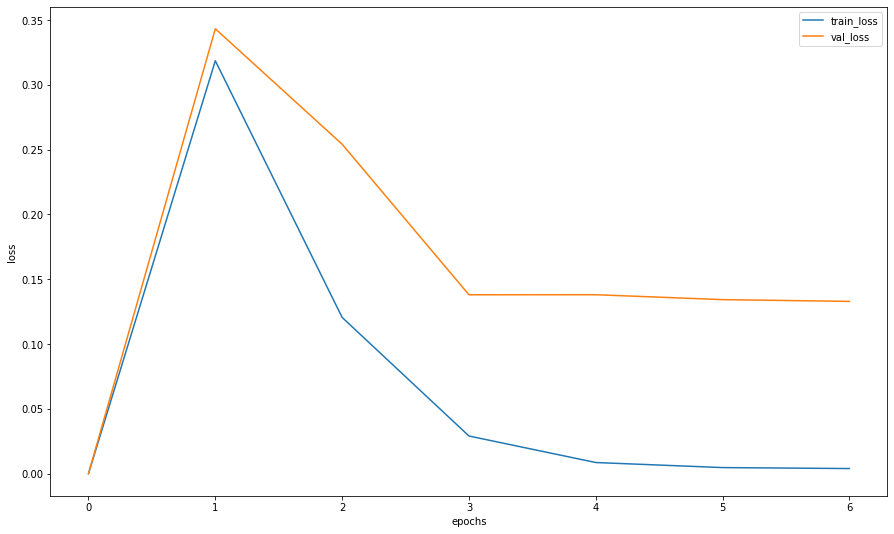

In [38]:
loss, acc, val_loss, val_acc = *train, *val
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

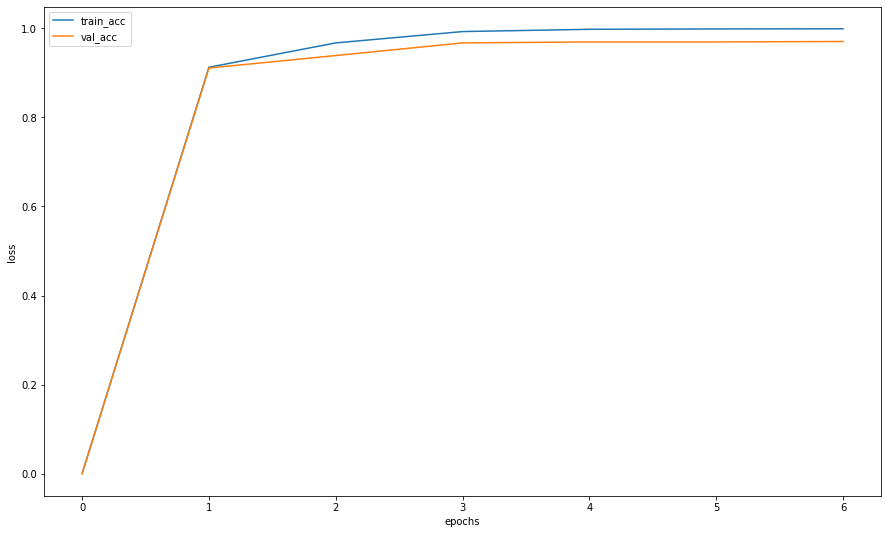

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Остаток

In [ ]:
summary(stack_of_models[0])

In [ ]:
for name, param in model.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=====')

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = 1.0e-2, amsgrad = True)
        sheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, sheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            
    return history

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = 1.0e-2, amsgrad = True)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.3)
        criterion = nn.CrossEntropyLoss()

        train_model(model, criterion, opt, scheduler, epochs, train_loader, val_loader)           
            
    return history

### Ну и что теперь со всем этим делать?

Запустим сеть на тестовых данных.

In [40]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [41]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [42]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [43]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model.cuda(), ex_img.unsqueeze(0))

In [44]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [45]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [46]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [47]:
#resnet50_2
f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

In [ ]:
#resnet50_1
f1_score(actual_labels, y_pred, average='micro')

0.9

In [ ]:
#resnet50
f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

In [ ]:
#resnet152
f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

In [ ]:
#best resnet18
f1_score(actual_labels, y_pred, average='micro')

0.9

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

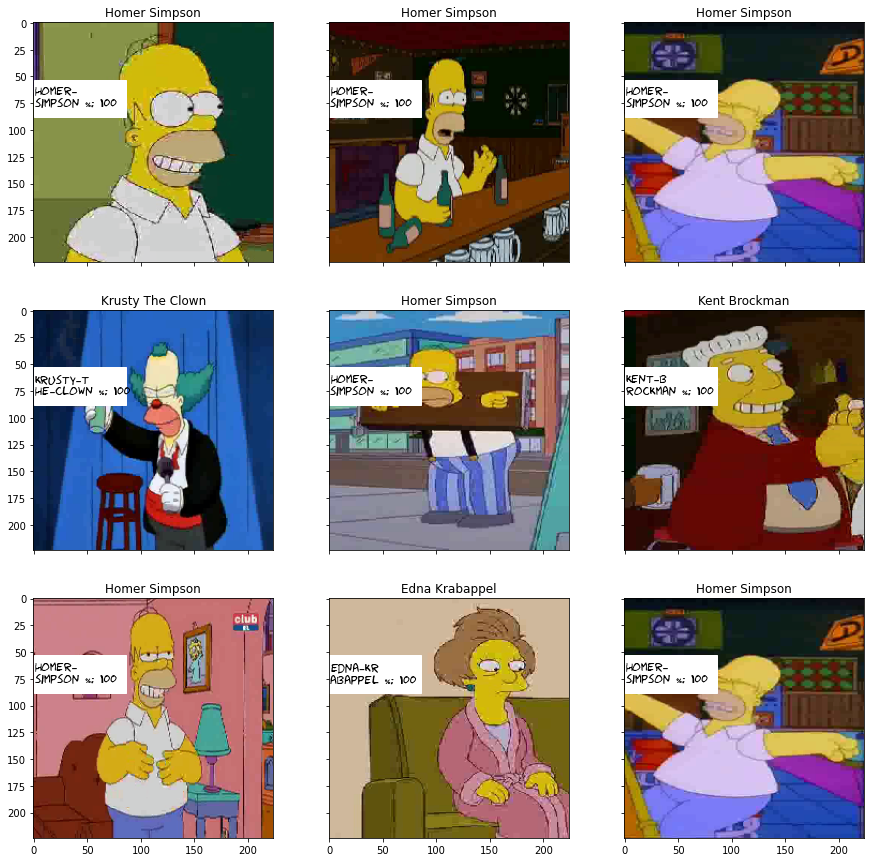

In [48]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(1000,2000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} %: {:.0f}".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=12, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

In [49]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [50]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [51]:
my_submit.iloc[50:100]

,Id,Expected
50,img143.jpg,mayor_quimby
51,img144.jpg,charles_montgomery_burns
52,img145.jpg,apu_nahasapeemapetilon
53,img146.jpg,mayor_quimby
54,img147.jpg,bart_simpson
55,img148.jpg,edna_krabappel
56,img149.jpg,edna_krabappel
57,img15.jpg,charles_montgomery_burns
58,img150.jpg,ned_flanders
59,img151.jpg,chief_wiggum


In [52]:
my_submit.to_csv('./resnet50_submission.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
